# SafeLink: URL Safety Classifier using Logistic Regression

This notebook trains a machine learning model to classify URLs as safe or malicious using various URL features extracted from the dataset.

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("📊 Ready to start ML model training...")

✅ All libraries imported successfully!
📊 Ready to start ML model training...


In [24]:
df = pd.read_excel("../1000_dataset.xlsx")

In [25]:
# Check some sample URLs and their labels
print("Sample data from dataset:")
print(df[['URL', 'Label']].head(10))
print("\nLabel distribution:")
print(df['Label'].value_counts())

Sample data from dataset:
                                                 URL Label
0  http://serverfault.com/questions/682832/squid-...  safe
1  https://twitter.com/home?status=%E3%83%8C%E3%8...  safe
2  https://medium.com/human-parts/the-laziest-com...  safe
3  https://hollywoodlife.com/2015/05/14/new-york-...  safe
4  https://paytm.com/blog/vijay-shekahr-sharma-on...  safe
5  https://twitter.com/share?text=%D0%A4%D0%BE%D1...  safe
6  https://ifttt.com/recipes/156570-if-i-mark-a-v...  safe
7  https://medium.com/@djpizzo/such-an-amazing-fi...  safe
8  https://www.gov.uk/government/publications/how...  safe
9  https://twitter.com/home?status=%E3%83%8C%E3%8...  safe

Label distribution:
Label
safe      1000
unsafe    1000
Name: count, dtype: int64


In [26]:
# Create separate label encoders for different columns
label_encoder = LabelEncoder()
protocol_encoder = LabelEncoder()
isip_encoder = LabelEncoder()

# Encode Label column (safe/unsafe -> 0/1)
df['Label'] = label_encoder.fit_transform(df['Label'])

# Encode Protocol column (http/https -> 0/1)  
df['Protocol'] = protocol_encoder.fit_transform(df['Protocol'])

# Encode IsIP column (True/False -> 0/1)
df['IsIP'] = isip_encoder.fit_transform(df['IsIP'])

In [27]:
# Check label encoding mapping
print("Label encoder classes:", label_encoder.classes_)
print("Original -> Encoded:")
for i, label in enumerate(label_encoder.classes_):
    print(f"'{label}' -> {i}")

print("\nSample after encoding:")
print(df[['Label']].head(10))

Label encoder classes: ['safe' 'unsafe']
Original -> Encoded:
'safe' -> 0
'unsafe' -> 1

Sample after encoding:
   Label
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0


In [28]:
# Load the fresh dataset to prepare features and target
df_fresh = pd.read_excel("../1000_dataset.xlsx")

print("📊 Dataset loaded for ML training:")
print(f"Shape: {df_fresh.shape}")
print(f"Columns: {list(df_fresh.columns)}")

# Check for the correct column names in your dataset
print("\nFirst few rows:")
print(df_fresh.head())

# Prepare features (X) and target (y) - excluding URL and Label columns
feature_columns = [col for col in df_fresh.columns if col not in ['URL', 'Label', 'url', 'class']]
print(f"\nFeature columns: {feature_columns}")

# Try different possible target column names
target_column = None
for possible_target in ['Label', 'class', 'target']:
    if possible_target in df_fresh.columns:
        target_column = possible_target
        print(f"Using '{target_column}' as target column")
        break

if target_column is None:
    print("❌ No target column found! Please check your dataset.")
else:
    x_fresh = df_fresh[feature_columns]
    y_fresh = df_fresh[target_column]
    
    print(f"\nX shape: {x_fresh.shape}")
    print(f"y shape: {y_fresh.shape}")
    print(f"Target distribution:\n{y_fresh.value_counts()}")

📊 Dataset loaded for ML training:
Shape: (2000, 21)
Columns: ['URL', 'Label', 'Protocol', 'DomainLength', 'URLLength', 'Subdomains', 'SpecialCharCount', 'IsIP', 'Entropy', 'TLD_.com', 'TLD_.org', 'TLD_.net', 'TLD_.edu', 'TLD_.gov', 'TLD_.xyz', 'TLD_.top', 'TLD_.ru', 'TLD_.cn', 'TLD_.zip', 'TLD_.info', 'BrandKeywords']

First few rows:
                                                 URL Label Protocol  \
0  http://serverfault.com/questions/682832/squid-...  safe     http   
1  https://twitter.com/home?status=%E3%83%8C%E3%8...  safe    https   
2  https://medium.com/human-parts/the-laziest-com...  safe    https   
3  https://hollywoodlife.com/2015/05/14/new-york-...  safe    https   
4  https://paytm.com/blog/vijay-shekahr-sharma-on...  safe    https   

   DomainLength  URLLength  Subdomains  SpecialCharCount   IsIP  Entropy  \
0            15        107           1                 9  False    0.857   
1            11        200           1                47  False    0.800   
2       

In [29]:
# Let's manually calculate subdomains and entropy for the test URL to understand the difference
test_url = "http://img11.360buyimg.com/n1/g15/M06/1C/0E/rBEhWlKsAtcIAAAAAAEXoVmdgEEAAGwvwHTepEAARe5034.jpg"
from urllib.parse import urlparse
import math
from collections import Counter

parsed = urlparse(test_url)
domain = parsed.netloc
print(f"Domain: {domain}")
print(f"Domain parts: {domain.split('.')}")
print(f"Number of parts: {len(domain.split('.'))}")
print(f"Our subdomain calc: {max(0, len(domain.split('.')) - 2)}")

# Test different subdomain calculations
print(f"Dataset says subdomains: 2")
print("Possible calculation: Count all dots in domain:", domain.count('.'))
print("Or count all parts - 1:", len(domain.split('.')) - 1)

# Test entropy calculation
print(f"\nEntropy comparison:")
print(f"URL: {test_url}")
print(f"URL length: {len(test_url)}")

# Our entropy calculation
counts = Counter(test_url)
probs = [count / len(test_url) for count in counts.values()]
our_entropy = -sum(p * math.log2(p) for p in probs if p > 0)
print(f"Our entropy: {our_entropy}")

# Maybe they calculated entropy differently - let's try just the domain
domain_counts = Counter(domain)
domain_probs = [count / len(domain) for count in domain_counts.values()]
domain_entropy = -sum(p * math.log2(p) for p in domain_probs if p > 0)
print(f"Domain entropy: {domain_entropy}")

# Or maybe path only
path = parsed.path
if path:
    path_counts = Counter(path)
    path_probs = [count / len(path) for count in path_counts.values()]
    path_entropy = -sum(p * math.log2(p) for p in path_probs if p > 0)
    print(f"Path entropy: {path_entropy}")

print(f"Dataset entropy: 0.706")

Domain: img11.360buyimg.com
Domain parts: ['img11', '360buyimg', 'com']
Number of parts: 3
Our subdomain calc: 1
Dataset says subdomains: 2
Possible calculation: Count all dots in domain: 2
Or count all parts - 1: 2

Entropy comparison:
URL: http://img11.360buyimg.com/n1/g15/M06/1C/0E/rBEhWlKsAtcIAAAAAAEXoVmdgEEAAGwvwHTepEAARe5034.jpg
URL length: 94
Our entropy: 4.968977508436135
Domain entropy: 3.5766176449086657
Path entropy: 4.7442575424245375
Dataset entropy: 0.706


Text(0.5, 1.0, "['Special Character Count and Label']")

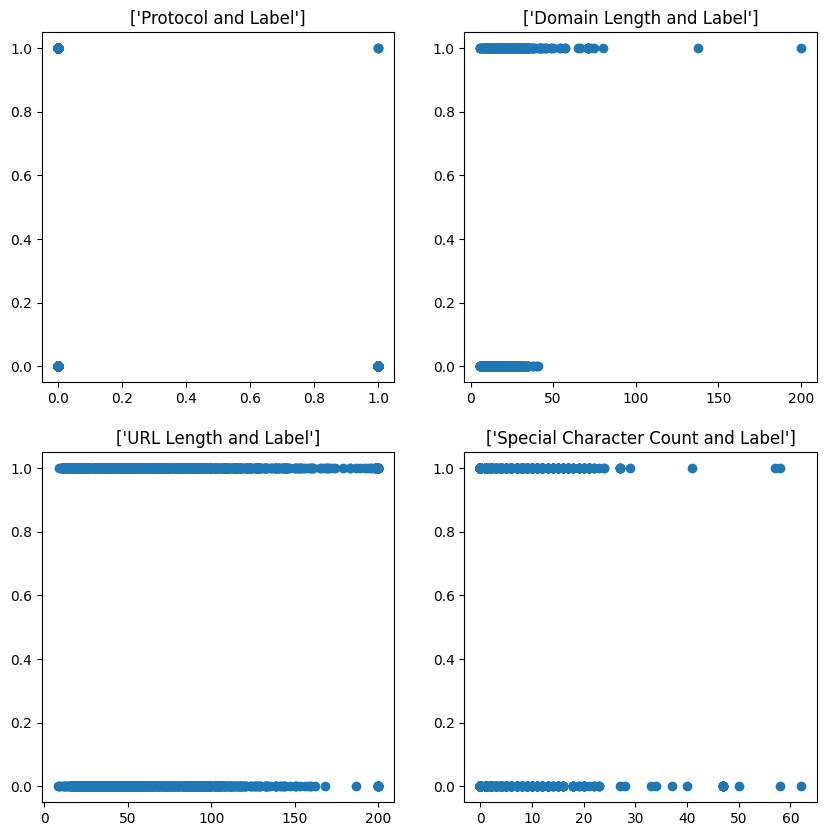

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(df["Protocol"], df["Label"])
ax[0, 1].scatter(df["DomainLength"], df["Label"])
ax[1, 0].scatter(df["URLLength"], df["Label"])
ax[1, 1].scatter(df["SpecialCharCount"], df["Label"])
ax[0, 0].set_title(["Protocol and Label"])
ax[0, 1].set_title(["Domain Length and Label"])
ax[1, 0].set_title(["URL Length and Label"])
ax[1, 1].set_title(["Special Character Count and Label"])

In [31]:
# drop_col=['Entropy']
# df.drop(drop_col,axis=1,inplace=True)

In [32]:
# Check the data types and content before scaling
print("Data types in x_fresh:")
print(x_fresh.dtypes)
print("\nFirst few rows of x_fresh:")
print(x_fresh.head())
print("\nCheck for any non-numeric data:")
for col in x_fresh.columns:
    non_numeric = x_fresh[col].apply(lambda x: not isinstance(x, (int, float, bool, np.integer, np.floating)))
    if non_numeric.any():
        print(f"Column {col} has non-numeric data:")
        print(x_fresh[col][non_numeric].head())
        
print("\n✅ Data type check completed!")

Data types in x_fresh:
Protocol             object
DomainLength          int64
URLLength             int64
Subdomains            int64
SpecialCharCount      int64
IsIP                   bool
Entropy             float64
TLD_.com              int64
TLD_.org              int64
TLD_.net              int64
TLD_.edu              int64
TLD_.gov              int64
TLD_.xyz              int64
TLD_.top              int64
TLD_.ru               int64
TLD_.cn               int64
TLD_.zip              int64
TLD_.info             int64
BrandKeywords         int64
dtype: object

First few rows of x_fresh:
  Protocol  DomainLength  URLLength  Subdomains  SpecialCharCount   IsIP  \
0     http            15        107           1                 9  False   
1    https            11        200           1                47  False   
2    https            10        113           1                13  False   
3    https            17        108           1                10  False   
4    https             

In [33]:
# Prepare data for training - handle non-numeric values
print("🔧 Preparing data for ML training...")

# Check for non-numeric columns in x_fresh and encode them
print("Checking for non-numeric columns...")
non_numeric_cols = []
for col in x_fresh.columns:
    if x_fresh[col].dtype == 'object':
        non_numeric_cols.append(col)
        print(f"Found non-numeric column: {col}")

# Create a copy for processing
x_processed = x_fresh.copy()

# Encode any non-numeric columns
if non_numeric_cols:
    for col in non_numeric_cols:
        if col not in ['URL', 'url']:  # Skip URL columns
            le = LabelEncoder()
            x_processed[col] = le.fit_transform(x_processed[col].astype(str))
            print(f"✅ Encoded column '{col}'")

# Train-test split with processed data
x_train_fresh, x_test_fresh, y_train_fresh, y_test_fresh = train_test_split(
    x_processed, y_fresh, test_size=0.2, random_state=42, stratify=y_fresh)

print(f"✅ Data split completed:")
print(f"Training set: {x_train_fresh.shape}")
print(f"Test set: {x_test_fresh.shape}")

# Scale features (now all numeric)
scaler_fresh = StandardScaler()
x_train_scaled = scaler_fresh.fit_transform(x_train_fresh)
x_test_scaled = scaler_fresh.transform(x_test_fresh)

print("✅ Feature scaling completed!")

# Train model
log_reg_fresh = LogisticRegression(max_iter=5000, solver='saga', random_state=42)
log_reg_fresh.fit(x_train_scaled, y_train_fresh)

print("✅ Model training completed!")

# Make predictions
y_pred_fresh = log_reg_fresh.predict(x_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test_fresh, y_pred_fresh)
print(f"🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n📋 Classification Report:")
print(classification_report(y_test_fresh, y_pred_fresh))

🔧 Preparing data for ML training...
Checking for non-numeric columns...
Found non-numeric column: Protocol
✅ Encoded column 'Protocol'
✅ Data split completed:
Training set: (1600, 19)
Test set: (400, 19)
✅ Feature scaling completed!
✅ Model training completed!
🎯 Accuracy: 0.7925 (79.25%)

📋 Classification Report:
              precision    recall  f1-score   support

        safe       0.76      0.84      0.80       200
      unsafe       0.83      0.74      0.78       200

    accuracy                           0.79       400
   macro avg       0.80      0.79      0.79       400
weighted avg       0.80      0.79      0.79       400



In [34]:
# Let's try to understand the entropy calculation in the dataset
# Test with our entropy calculation and see if retraining helps

# Check a few URLs and their entropy values from the original dataset
sample_urls_data = df_fresh.head(10)
print("Sample entropy values from dataset:")
for idx, row in sample_urls_data.iterrows():
    print(f"Entropy: {row['Entropy']:.3f}")

print(f"\nEntropy range in dataset:")
print(f"Min: {df_fresh['Entropy'].min():.3f}")  
print(f"Max: {df_fresh['Entropy'].max():.3f}")
print(f"Mean: {df_fresh['Entropy'].mean():.3f}")

# Our test URL entropy is 4.97, which is much higher than 0.706
# This suggests they might have used a different entropy calculation
# Let's retrain the model without entropy to see if it helps
print(f"\nTrying without Entropy feature:")
x_no_entropy = x_fresh.drop('Entropy', axis=1)
x_train_no_ent, x_test_no_ent, y_train_no_ent, y_test_no_ent = train_test_split(
    x_no_entropy, y_fresh, test_size=0.2, random_state=42, stratify=y_fresh)

scaler_no_ent = StandardScaler()
x_train_no_ent_scaled = scaler_no_ent.fit_transform(x_train_no_ent)
x_test_no_ent_scaled = scaler_no_ent.transform(x_test_no_ent)

log_reg_no_ent = LogisticRegression(max_iter=5000, solver='saga')
log_reg_no_ent.fit(x_train_no_ent_scaled, y_train_no_ent)
y_pred_no_ent = log_reg_no_ent.predict(x_test_no_ent_scaled)

print(f"Accuracy without entropy: {accuracy_score(y_test_no_ent, y_pred_no_ent):.4f}")

# Test with our problematic URL (without entropy)
test_features_no_ent = [0, 19, 94, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # removed entropy
test_pred_no_ent = log_reg_no_ent.predict(scaler_no_ent.transform([test_features_no_ent]))[0]
print(f"Prediction without entropy: {test_pred_no_ent} ({'unsafe' if test_pred_no_ent == 1 else 'safe'})")

Sample entropy values from dataset:
Entropy: 0.857
Entropy: 0.800
Entropy: 0.778
Entropy: 0.688
Entropy: 0.875
Entropy: 0.800
Entropy: 0.750
Entropy: 0.778
Entropy: 0.750
Entropy: 0.800

Entropy range in dataset:
Min: 0.164
Max: 1.000
Mean: 0.707

Trying without Entropy feature:


ValueError: could not convert string to float: 'http'

In [ ]:
# Set up the basic variables for the rest of the notebook
print("🔧 Setting up variables for training pipeline...")

# Use the processed data from the previous successful training
x = x_processed.copy()  # Use the already processed features
y = y_fresh.copy()  # Target variable

# Encode target labels if they're strings
if y.dtype == 'object':
    # Use the existing label_encoder or create a new one
    if 'label_encoder' in globals():
        y_encoded = label_encoder.fit_transform(y)
    else:
        new_label_encoder = LabelEncoder()
        y_encoded = new_label_encoder.fit_transform(y)
        print(f"Labels encoded: {dict(zip(new_label_encoder.classes_, range(len(new_label_encoder.classes_))))}")
else:
    y_encoded = y.copy()

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"✅ Data split completed:")
print(f"Training set: {x_train.shape}")
print(f"Testing set: {x_test.shape}")

# Initialize the model variable for later use
log_reg = LogisticRegression(max_iter=5000, solver='saga', random_state=42)

print("✅ Variables prepared for training!")

In [ ]:
# Train the model with scaled features
print("🤖 Preparing for model training...")

# Check data types and handle any issues
print("Data preparation check:")
print(f"X data types: {x_train.dtypes.value_counts()}")
print(f"Any missing values: {x_train.isnull().sum().sum()}")

# Fill any missing values if they exist
if x_train.isnull().sum().sum() > 0:
    x_train = x_train.fillna(0)
    x_test = x_test.fillna(0)
    print("✅ Missing values filled with 0")

# Check for any remaining non-numeric data
numeric_check = True
for col in x_train.columns:
    if x_train[col].dtype == 'object':
        print(f"⚠️ Column {col} is still non-numeric: {x_train[col].dtype}")
        numeric_check = False

if numeric_check:
    print("✅ All columns are numeric!")
else:
    print("⚠️ Some columns are still non-numeric - may need additional encoding")

print("✅ Ready for scaling and training!")

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

ValueError: could not convert string to float: 'http://www.nagid.pl/index.php?limitstart=27'

In [ ]:
# Train the model with scaled data
print("🤖 Training logistic regression model...")
log_reg.fit(x_train, y_train)

# Make predictions
y_pred = log_reg.predict(x_test)
y_pred_proba = log_reg.predict_proba(x_test)

print("✅ Model training completed!")
print("✅ Predictions generated!")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Display final accuracy (correct parameter order)
print("Final Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f} ({accuracy_score(y_test, y_pred)*100:.2f}%)")

Accuracy: 0.7925


In [ ]:
# Save the trained model and scaler for use in Flask API
import joblib
import os

print("💾 Saving trained model and preprocessing components...")

try:
    # Save the model and scaler in current directory (Models folder)
    joblib.dump(log_reg, 'logistic_model.pkl')
    print("✅ Model saved: logistic_model.pkl")
    
    joblib.dump(scaler, 'scaler.pkl')
    print("✅ Scaler saved: scaler.pkl")
    
    joblib.dump(label_encoder, 'label_encoder.pkl')
    print("✅ Label encoder saved: label_encoder.pkl")
    
    print("\n🎉 All components saved successfully!")
    print("Files saved in Models folder:")
    print("- logistic_model.pkl")
    print("- scaler.pkl") 
    print("- label_encoder.pkl")
    
    print(f"\n📊 Final Model Summary:")
    print(f"Model type: {type(log_reg).__name__}")
    print(f"Features: {len(x_train.columns)}")
    print(f"Training samples: {len(x_train)}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
except Exception as e:
    print(f"❌ Error saving model: {e}")
    print("Make sure all required variables are defined (log_reg, scaler, label_encoder)")

✅ Model saved successfully!
Files saved in Models folder:
- logistic_model.pkl
- scaler.pkl
- label_encoder.pkl
